<a href="https://colab.research.google.com/github/ShreeyashGo/SAiDL_Spring_Assignment/blob/main/%5CCV%5CCV_SuperResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import keras
from PIL import Image

In [ ]:
from bs4 import BeautifulSoup
import re
import requests
import os
import tarfile

# make sure you are in the required directory
# if you want you can change it with os.chdir(<filePath>) command

sito = 'https://www.robots.ox.ac.uk/~vgg/data/pets/'
responsess= requests.get(sito)
soup = BeautifulSoup(responsess.text, 'html.parser')
arxf= soup.find_all('a')
a = [arx['href'] for arx in arxf]
images = requests.get(sito+a[5])  
f = open("dataset.gz", 'wb')
f.write(images.content)
f.close()
annotations = requests.get(sito+a[6])
f = open("annotations.gz", 'wb')
f.write(annotations.content)
f.close()


file = tarfile.open('dataset.gz')  
file.extractall()
file.close()

file = tarfile.open('annotations.gz')  
file.extractall()
file.close()

# this should run within a minute or two :)

In [ ]:
datalist = os.listdir('./images')
for i in datalist:
    if '.jpg' not in i:
        datalist.pop(datalist.index(i))

print(f'number of images:', len(datalist))

number of images: 7390


In [ ]:
sizes =[]
for i in datalist:
    sizes.append(np.array(Image.open('./images/'+i).convert("RGB")).shape)
sizes=np.array(sizes)

print(f'min h dim: {min(sizes[:,0])}')
print(f'min w dim: {min(sizes[:,1])}')
# so we will use the min of these
dim = min(min(sizes[:,0]), min(sizes[:,1]))

min h dim: 103
min w dim: 114


In [ ]:
try:
    os.mkdir('/content/Dataset')
except:
    print("directory already exists")
os.chdir('/content/Dataset')
for i in range(len(datalist)):
    img =Image.open(f'/content/images/{datalist[i]}').convert("RGB")
    midx, midy = img.size[0]/2, img.size[1]/2
    (img.crop((midx-50, midy-50, midx+50, midy+50))).save(f'./{datalist[i]}')
    (img.crop((0, 0, 100, 100))).save(f'./top{datalist[i]}')
    (img.crop((img.size[0]-100, img.size[1]-100, img.size[0], img.size[1]))).save(f'./bottom{datalist[i]}')
    img.close()
#am taking multiple sub images so as to increase training dataset

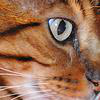

image size:(100, 100)


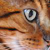

Nearest interpolation:


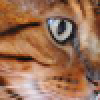

Bilinear interpolation:


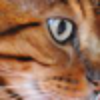

Bicubic interpolation:


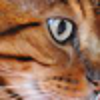

LANCZOS interpolation:


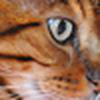

In [ ]:
#so now trying the normal upsampling filters
im = (Image.open('/content/Dataset/Bengal_110.jpg'))
display(im)
print(f'image size:{im.size}')

im = im.resize((50, 50)) #input to the SRCNN
display(im)

im_nearest = im.resize((100, 100), resample=Image.NEAREST)
print("Nearest interpolation:")
display(im_nearest)

im_bilinear = im.resize((100, 100), resample= Image.BILINEAR)
print("Bilinear interpolation:")
display(im_bilinear)

im_bicubic = im.resize((100, 100), resample=Image.BICUBIC)
print("Bicubic interpolation:")
display(im_bicubic)

im_lanc = im.resize((100, 100), resample= Image.LANCZOS)
print("LANCZOS interpolation:")
display(im_lanc)

In [ ]:
srcnn = keras.models.Sequential(
    [
        keras.layers.Input(shape=(50, 50, 3)),
        keras.layers.Resizing(100, 100, interpolation='bicubic'),
        keras.layers.Conv2D(kernel_size = (9, 9), filters = 64, activation = 'relu', padding='same'),
        keras.layers.Conv2D(kernel_size = (1, 1), filters = 32, activation = 'relu', padding = 'same'),
        keras.layers.Conv2D(kernel_size = (5,5), filters = 3, activation = 'sigmoid', padding ='same'),
    ]
)

In [ ]:
srcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      15616     
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 3)       2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

ImgGen = train_datagen.flow_from_directory('/content/', classes=['Dataset'], target_size = (50, 50), batch_size = 128, class_mode=None, shuffle =True, seed=7)
Imgs = train_datagen.flow_from_directory('/content/', classes=['Dataset'], target_size = (100, 100), batch_size = 128, class_mode=None, shuffle =True, seed=7)

Found 22170 images belonging to 1 classes.
Found 22170 images belonging to 1 classes.


In [ ]:
num_epochs = 20
optimizer = tf.keras.optimizers.Adam()
def reduceLronPlateau(psnr, patience = 10, tolerance=0.005):
    if abs(np.mean(psnr[-patience:])-psnr[-1])<tolerance:
        optimizer.learning_rate= optimizer.learning_rate*0.5
        print('changing lr')

epochPSNR=[]
for i in range(num_epochs):
    psnr= []
    print(f'Epoch {i+1}')
    print('----------------------')
    for indx in range(len(ImgGen)):
        y_true = Imgs[indx]
        x = ImgGen[indx]
        with tf.GradientTape() as tape:
            y_preds = srcnn(x, training = True)
            loss = tf.math.reduce_mean(keras.losses.mean_squared_error(y_true, y_preds))
        
        trainable_vars = srcnn.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        optimizer.apply_gradients(grads_and_vars = zip(gradients, trainable_vars), )
        psnr.append(tf.math.reduce_mean(tf.image.psnr(y_true*255, y_preds*255, max_val = 255)))
        if indx%10==0:
            print(f'psnr, loss till batch {indx+1}: {np.mean(psnr)}, {loss}')

    #something like a custom callback on ReduceLRonPlateau
    reduceLronPlateau(psnr, tolerance= 0.01) #on epoch end
    print(f'psnr on epoch {i+1}: {np.mean(psnr)}')
    epochPSNR.append(np.mean(psnr))
    print('----------------------')
    

Epoch 1
----------------------
psnr, loss till batch 1: 11.362295150756836, 0.09051380306482315
psnr, loss till batch 11: 12.426517486572266, 0.05921105295419693
psnr, loss till batch 21: 12.901460647583008, 0.051579371094703674
psnr, loss till batch 31: 13.472628593444824, 0.0418924055993557
psnr, loss till batch 41: 14.130115509033203, 0.02609901688992977
psnr, loss till batch 51: 15.094817161560059, 0.011577694676816463
psnr, loss till batch 61: 15.87445068359375, 0.00818958692252636
psnr, loss till batch 71: 16.333724975585938, 0.008523780852556229
psnr, loss till batch 81: 16.98371696472168, 0.006625401321798563
psnr, loss till batch 91: 17.62359619140625, 0.006836581975221634
psnr, loss till batch 101: 18.22727394104004, 0.0051172696985304356
psnr, loss till batch 111: 18.74677276611328, 0.005277093034237623
psnr, loss till batch 121: 19.207015991210938, 0.0058327424339950085
psnr, loss till batch 131: 19.59848976135254, 0.004670678172260523
psnr, loss till batch 141: 19.95754432

In [ ]:
srcnn.save('/content/srcnn')


INFO:tensorflow:Assets written to: /content/srcnn/assets


In [ ]:
import shutil

shutil.make_archive('/content/srcnn', 'zip', '/content/srcnn')

'/content/srcnn.zip'

<function matplotlib.pyplot.show>

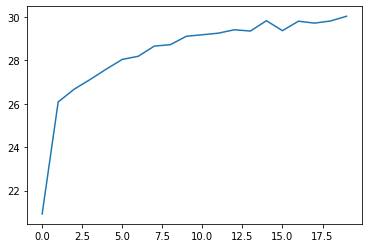

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epochPSNR)
plt.show

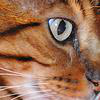

image size:(100, 100)


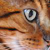

Bicubic interpolation:


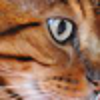

LANCZOS interpolation:


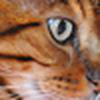

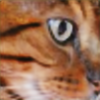

In [ ]:
#now lets see how it works against bicubic and lanczos
im = (Image.open('/content/Dataset/Bengal_110.jpg'))
display(im)
print(f'image size:{im.size}')

im = im.resize((50, 50)) #input to the SRCNN
display(im)

im_bicubic = im.resize((100, 100), resample=Image.BICUBIC)
print("Bicubic interpolation:")
display(im_bicubic)

im_lanc = im.resize((100, 100), resample= Image.LANCZOS)
print("LANCZOS interpolation:")
display(im_lanc)

print("srcnn o/p:")
display(
    Image.fromarray(
        np.uint8(
            (srcnn.predict(np.array([np.array(im)/255])).reshape(100,100,3)*255))).convert('RGB'))

In [ ]:
# due to time restrictions I did not code the Residual Block myself, instead used the code from
# https://d2l.ai/chapter_convolutional-modern/resnet.html#:~:text=The%20difference%20is%20the%20batch,each%20convolutional%20layer%20in%20ResNet.&text=GoogLeNet%20uses%20four%20modules%20made,same%20number%20of%20output%20channels.
# thanks to d2l for the elaborate code and explanation

class Residual(tf.keras.Model): 
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same', kernel_size=3)
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(num_channels, kernel_size=1)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.prelu1 = tf.keras.layers.PReLU(alpha_initializer= 'ones')
        self.prelu2 = tf.keras.layers.PReLU(alpha_initializer= 'ones')

    def call(self, X):
        Y = self.prelu1(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return self.prelu2(alpha_initializer= 'ones')(Y)


class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False, **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(Residual(num_channels, use_1x1conv=True))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

    # def get_config(self):
    #     config = super(ResnetBlock, self).get_config()
    #     config.update({
    #         'conv1': self.conv1,
    #         'conv2': self.conv2,
    #         'b1': self.b1,
    #         'b2':self.b2,
    #         'prelu1':self.prelu1,
    #         'prelu2':self.prelu2,
    #         'embed_dim': self.embed_dim,
    #         'num_heads':self.num_heads,
    #         'ff_dim':self.ff_dim 
    #     })
    #     return config
    #work in progress to save the model!

In [ ]:
# Unlike the paper due to computational restrictions, I will use 3 residual blocks instead of the normal 16
#each block has 2 convolution layers as is

input_layer = tf.keras.layers.Input(shape = (50, 50, 3))
L1 = keras.layers.Conv2D(kernel_size=9, filters=64, padding='same')(input_layer)
SRResNet_skip = L1
L2 = ResnetBlock(num_channels=64, num_residuals= 3, first_block=True)(L1)
L3 = ResnetBlock(num_channels=64, num_residuals= 3)(L2)
L4 = ResnetBlock(num_channels=64, num_residuals= 3)(L3)
L5 = keras.layers.Conv2D(kernel_size=3, filters=64, padding = "same")(L4)
L5 = tf.keras.layers.Add()([L5, SRResNet_skip])
L6 = tf.nn.depth_to_space(L5, block_size=2, name="EPSCN_1")
output_layer = keras.layers.Conv2D(kernel_size=9, filters=3, activation="sigmoid", padding="same")(L6)

SRResNet = tf.keras.Model(inputs=input_layer, outputs=output_layer)
SRResNet.compile(optimizer='adam', loss='mse')

SRResNet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 50, 50, 64)   15616       ['input_2[0][0]']                
                                                                                                  
 resnet_block (ResnetBlock)     (None, 50, 50, 64)   223104      ['conv2d_3[0][0]']               
                                                                                                  
 resnet_block_1 (ResnetBlock)   (None, 50, 50, 64)   227264      ['resnet_block[0][0]']           
                                                                                              

In [ ]:
num_epochs = 20
optimizer = tf.keras.optimizers.Adam()
def reduceLronPlateau(psnr, patience = 10, tolerance=0.005):
    # print(np.mean(psnr[-patience:]), psnr[-1], np.mean(psnr[-patience:])-psnr[-1])
    if abs(np.mean(psnr[-patience:])-psnr[-1])<tolerance:
        optimizer.learning_rate= optimizer.learning_rate*0.5
        print('changing lr')

epochPSNR=[]
for i in range(num_epochs):
    psnr= []
    print(f'Epoch {i+1}')
    print('----------------------')
    for indx in range(len(ImgGen)):
        y_true = Imgs[indx]
        x = ImgGen[indx]
        with tf.GradientTape() as tape:
            y_preds = SRResNet(x, training = True)
            loss = tf.math.reduce_mean(keras.losses.mean_squared_error(y_true, y_preds))
        
        trainable_vars = SRResNet.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        optimizer.apply_gradients(grads_and_vars = zip(gradients, trainable_vars), )
        psnr.append(tf.math.reduce_mean(tf.image.psnr(y_true*255, y_preds*255, max_val = 255)))
        if indx%10==0:
            print(f'psnr, loss till batch {indx+1}: {np.mean(psnr)}, {loss}')

        if indx%25==0 and indx!=0:
            #something like a custom callback on ReduceLRonPlateau
            reduceLronPlateau(psnr, tolerance= 0.01) #on epoch end
    print(f'psnr on epoch {i+1}: {np.mean(psnr)}')
    epochPSNR.append(np.mean(psnr))
    print('----------------------')
    

Epoch 1
----------------------
psnr, loss till batch 1: 7.423884391784668, 0.1868642419576645
psnr, loss till batch 11: 10.676450729370117, 0.08774733543395996
psnr, loss till batch 21: 10.910684585571289, 0.08314338326454163
psnr, loss till batch 31: 11.244718551635742, 0.06460479646921158
psnr, loss till batch 41: 11.481111526489258, 0.06791975349187851
psnr, loss till batch 51: 11.865376472473145, 0.03649180755019188
psnr, loss till batch 61: 12.732218742370605, 0.012906808406114578
psnr, loss till batch 71: 13.843528747558594, 0.008373953402042389
psnr, loss till batch 81: 14.805184364318848, 0.007484848145395517
psnr, loss till batch 91: 15.630674362182617, 0.006805532146245241
psnr, loss till batch 101: 16.357219696044922, 0.00534108467400074
psnr, loss till batch 111: 16.977251052856445, 0.007288961671292782
psnr, loss till batch 121: 17.465604782104492, 0.0065421187318861485
psnr, loss till batch 131: 17.943262100219727, 0.004452836234122515
psnr, loss till batch 141: 18.391000

In [ ]:
np.save('/content/SRResNet', np.array(SRResNet.get_weights()))

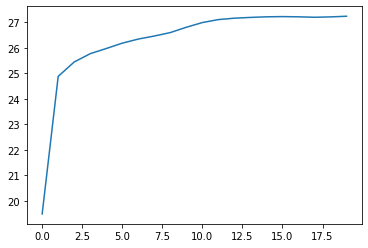

In [ ]:
plt.plot(epochPSNR)
plt.show()

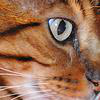

image size:(100, 100)


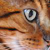

Bicubic interpolation:


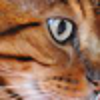

LANCZOS interpolation:


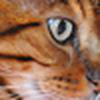

srcnn o/p:


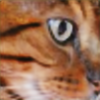

srresnet o/p:


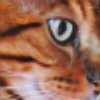

In [ ]:
#now lets see how it works against bicubic and lanczos
im = (Image.open('/content/Dataset/Bengal_110.jpg'))
display(im)
print(f'image size:{im.size}')

im = im.resize((50, 50)) #input to the SRCNN
display(im)

im_bicubic = im.resize((100, 100), resample=Image.BICUBIC)
print("Bicubic interpolation:")
display(im_bicubic)

im_lanc = im.resize((100, 100), resample= Image.LANCZOS)
print("LANCZOS interpolation:")
display(im_lanc)

print("srcnn o/p:")
display(
    Image.fromarray(
        np.uint8(
            (srcnn.predict(np.array([np.array(im)/255])).reshape(100,100,3)*255))).convert('RGB'))

print("srresnet o/p:")
display(
    Image.fromarray(
        np.uint8(
            ((SRResNet(np.array([np.array(im)/255]))).numpy().reshape(100,100,3)*255))).convert('RGB'))



In [ ]:
input_layer = tf.keras.layers.Input(shape = (50, 50, 3))
L1 = keras.layers.Conv2D(kernel_size=9, filters=64, padding='same')(input_layer)
SRResNet_skip = L1
L2 = ResnetBlock(num_channels=64, num_residuals= 3, first_block=True)(L1)
L3 = ResnetBlock(num_channels=64, num_residuals= 3)(L2)
L4 = ResnetBlock(num_channels=64, num_residuals= 3)(L3)
L5 = keras.layers.Conv2D(kernel_size=3, filters=64, padding = "same")(L4)
L5 = tf.keras.layers.Add()([L5, SRResNet_skip])
L6 = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = 2, strides = 2)(L5)
output_layer = keras.layers.Conv2D(kernel_size=9, filters=3, activation="sigmoid", padding="same")(L6)

modSRResNet = tf.keras.Model(inputs=input_layer, outputs=output_layer)
modSRResNet.compile(optimizer='adam', loss='mse')

modSRResNet.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d_141 (Conv2D)            (None, 50, 50, 64)   15616       ['input_8[0][0]']                
                                                                                                  
 resnet_block_18 (ResnetBlock)  (None, 50, 50, 64)   223104      ['conv2d_141[0][0]']             
                                                                                                  
 resnet_block_19 (ResnetBlock)  (None, 50, 50, 64)   227264      ['resnet_block_18[0][0]']        
                                                                                            

In [ ]:
num_epochs = 20
optimizer = tf.keras.optimizers.Adam()
def reduceLronPlateau(psnr, patience = 10, tolerance=0.005):
    # print(np.mean(psnr[-patience:]), psnr[-1], np.mean(psnr[-patience:])-psnr[-1])
    if abs(np.mean(psnr[-patience:])-psnr[-1])<tolerance:
        optimizer.learning_rate= optimizer.learning_rate*0.5
        print('changing lr')

epochPSNR=[]
for i in range(num_epochs):
    psnr= []
    print(f'Epoch {i+1}')
    print('----------------------')
    for indx in range(len(ImgGen)):
        y_true = Imgs[indx]
        x = ImgGen[indx]
        with tf.GradientTape() as tape:
            y_preds = modSRResNet(x, training = True)
            loss = tf.math.reduce_mean(keras.losses.mean_squared_error(y_true, y_preds))
        
        trainable_vars = modSRResNet.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        optimizer.apply_gradients(grads_and_vars = zip(gradients, trainable_vars), )
        psnr.append(tf.math.reduce_mean(tf.image.psnr(y_true*255, y_preds*255, max_val = 255)))
        if indx%10==0:
            print(f'psnr, loss till batch {indx+1}: {np.mean(psnr)}, {loss}')

        if indx%25==0 and indx!=0:
            #something like a custom callback on ReduceLRonPlateau
            reduceLronPlateau(psnr, tolerance= 0.01) #on epoch end
    print(f'psnr on epoch {i+1}: {np.mean(psnr)}')
    epochPSNR.append(np.mean(psnr))
    print('----------------------')
    

Epoch 1
----------------------
psnr, loss till batch 1: 8.777918815612793, 0.14255112409591675
psnr, loss till batch 11: 12.397168159484863, 0.03154158219695091
psnr, loss till batch 21: 14.986528396606445, 0.012220458127558231
psnr, loss till batch 31: 16.72421646118164, 0.009830152615904808
psnr, loss till batch 41: 17.940479278564453, 0.008383887819945812
psnr, loss till batch 51: 18.68533706665039, 0.00931069441139698
psnr, loss till batch 61: 19.052404403686523, 0.007454134523868561
psnr, loss till batch 71: 19.454381942749023, 0.00725304801017046
psnr, loss till batch 81: 19.7722225189209, 0.007757015060633421
psnr, loss till batch 91: 20.077136993408203, 0.007517878897488117
psnr, loss till batch 101: 20.385007858276367, 0.005906832404434681
psnr, loss till batch 111: 20.639667510986328, 0.006954713258892298
psnr, loss till batch 121: 20.854068756103516, 0.006338737905025482
psnr, loss till batch 131: 21.072053909301758, 0.004511718638241291
psnr, loss till batch 141: 21.2939701

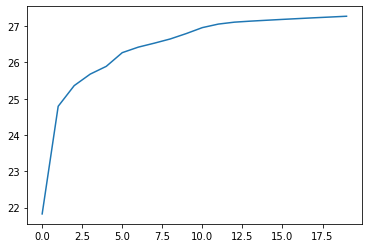

In [ ]:
plt.plot(epochPSNR)
plt.show()

In [ ]:
np.save('/content/convtransposeSRResNet', np.array(modSRResNet.get_weights()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


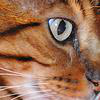

image size:(100, 100)


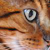

srcnn o/p:


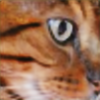

srresnet o/p:


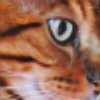

srresnet with convtranspose o/p:


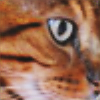

In [ ]:
#now lets see how it works against bicubic and lanczos
im = (Image.open('/content/Dataset/Bengal_110.jpg'))
display(im)
print(f'image size:{im.size}')

im = im.resize((50, 50)) #input to the SRCNN
display(im)

print("srcnn o/p:")
display(
    Image.fromarray(
        np.uint8(
            (srcnn.predict(np.array([np.array(im)/255])).reshape(100,100,3)*255))).convert('RGB'))

print("srresnet o/p:")
display(
    Image.fromarray(
        np.uint8(
            ((SRResNet(np.array([np.array(im)/255]))).numpy().reshape(100,100,3)*255))).convert('RGB'))

print("srresnet with convtranspose o/p:")
display(
    Image.fromarray(
        np.uint8(
            ((modSRResNet(np.array([np.array(im)/255]))).numpy().reshape(100,100,3)*255))).convert('RGB'))
